# SigNet: Convolutional Siamese Network for Writer Independent Offline Signature Verification

#### Presenting a Finetuning Tutorial for a State-of-the-art Solution for Signature Verification

Dataset => https://www.kaggle.com/datasets/ishanikathuria/handwritten-signature-datasets

* The above dataset contains Hindi,Bengali and CEDAR signatures.
* I have used only the Hindi Signature Dataset of 160 individuals.

References:

* https://arxiv.org/pdf/1707.02131.pdf  [Model Architecture]
* http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf [Vector Loss Function]
* https://github.com/netrapathak/Offline-Signature-Verification
* https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

#### Challenges:
* Updating codebase from Tensorflow v1 to Tensorflow 2.15.0 (Kaggle existing version)
* Updating custom function input and output DataTypes according to updated Tf v2 library, as lot of Tf v1 function has been DEPRICATED.
* Utilizing GPU for training

Current notebook in TESTED only on Kaggle. Please be cautioned to run it elsewhere.

If this notebook has helped you, please consider Upvoting. Thanks for your generous support.

In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

"""from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, ZeroPadding2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform"""

2024-06-18 11:18:22.216122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 11:18:22.216318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 11:18:22.375072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, ZeroPadding2D, Dropout, Flatten, Dense, Input\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras.initializers import glorot_uniform'

In [2]:
# Enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
path = "/kaggle/input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi/"

# Data Prep

In [4]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [5]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [6]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)      #List of list containing gen[160][24] and forge[160][30]

(160, 160)

In [7]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [8]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [9]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [10]:
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [11]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [12]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [13]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

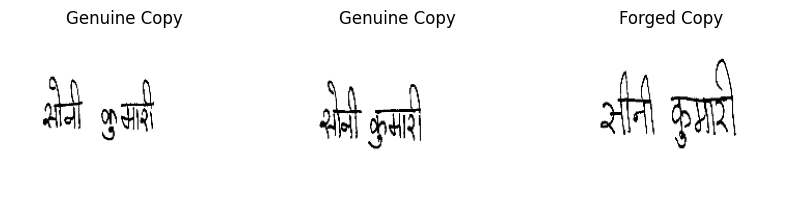

In [14]:
visualize_sample_signature()

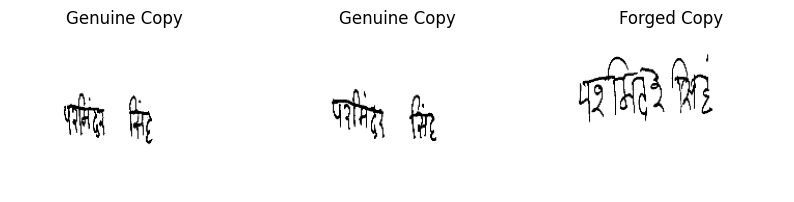

In [15]:
visualize_sample_signature()

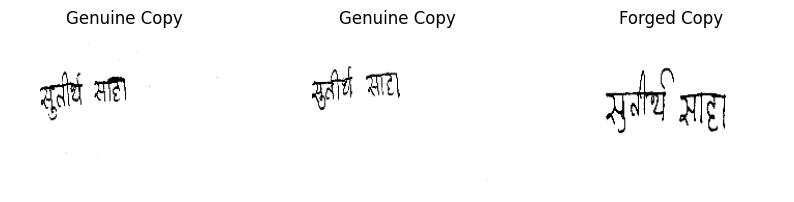

In [16]:
visualize_sample_signature()

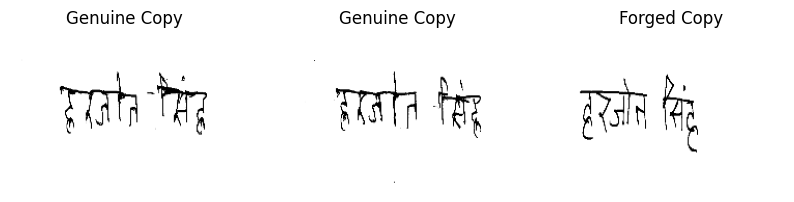

In [17]:
visualize_sample_signature()

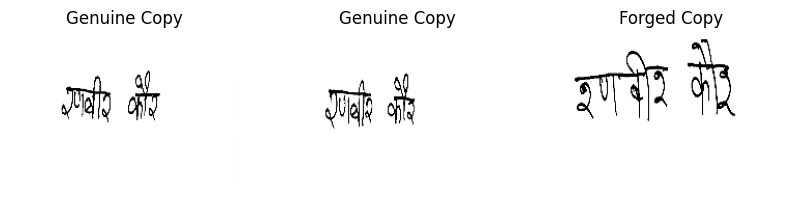

In [18]:
visualize_sample_signature()

# Data Pre-processing

In [19]:
def generate_batch(orig_groups, forg_groups, batch_size=32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    img_h, img_w = 155, 220  # Assuming image height and width are 155 and 220, respectively
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 (24C2)= 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            forg_list = list(forg)  # Ensure forg is a list
            for i in range(len(forg_list)):
                forg_pairs.extend(list(itertools.product(orig[i:i + 1], random.sample(forg_list, 12))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1] * len(orig_pairs)
        gen_for_labels = [0] * len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1), dtype=np.float32) for _ in range(2)]
        targets = np.zeros((batch_size,), dtype=np.float32)
        
        for ix, pair in enumerate(all_pairs):
            # Ensure pair elements are strings
            path1 = pair[0].decode('utf-8') if isinstance(pair[0], bytes) else pair[0]
            path2 = pair[1].decode('utf-8') if isinstance(pair[1], bytes) else pair[1]

            img1 = cv2.imread(path1, 0)
            img2 = cv2.imread(path2, 0)
            img1 = cv2.resize(img1, (img_w, img_h))          #Resizing Images
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype=np.float64)
            img2 = np.array(img2, dtype=np.float64)
            img1 /= 255                                     #Normalizing Images
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield (tf.convert_to_tensor(pairs[0], dtype=tf.float32), tf.convert_to_tensor(pairs[1], dtype=tf.float32)), tf.convert_to_tensor(targets, dtype=tf.float32)
                k = 0
                pairs = [np.zeros((batch_size, img_h, img_w, 1), dtype=np.float32) for _ in range(2)]
                targets = np.zeros((batch_size,), dtype=np.float32)

In [20]:
#Creating a tf Dataset from generator
def ensure_list(groups):
    return [list(group) if not isinstance(group, list) else group for group in groups]

orig_train = ensure_list(orig_train)
forg_train = ensure_list(forg_train)
orig_val = ensure_list(orig_val)
forg_val = ensure_list(forg_val)

def create_dataset(generator_func, orig_groups, forg_groups, batch_size, img_h, img_w):
    output_signature = (
        (
            tf.TensorSpec(shape=(batch_size, img_h, img_w, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, img_h, img_w, 1), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        generator_func,
        args=[orig_groups, forg_groups, batch_size],
        output_signature=output_signature
    )
    return dataset

# Model Training

In [21]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [22]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [23]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

![Model Architecture](https://github.com/GAURAV2567/Kaggle_CMI/blob/main/Model%20Architecture.JPG?raw=true)

##### Additional Details can be found in the Paper

In [24]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    seq = Sequential()
    seq.add(Input(shape=input_shape))  # Define input shape using an Input layer
    
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=-1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=-1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))  # softmax changed to relu
    
    return seq


In [25]:
input_shape=(img_h, img_w, 1)

base_network = create_base_network_signet(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [26]:
# Define the optimizer
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)

# Compile the model using the defined optimizer and a custom contrastive loss function
model.compile(loss=contrastive_loss, optimizer=rms)

In [27]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/kaggle/working/signet-bhsig260-{epoch:03d}.weights.h5', verbose=1, save_weights_only=True)
]

In [28]:
# Assuming img_h and img_w are 155 and 220 respectively
img_h, img_w = 155, 220
batch_sz = 128

train_dataset = create_dataset(generate_batch, orig_train, forg_train, batch_sz, img_h, img_w)
val_dataset = create_dataset(generate_batch, orig_val, forg_val, batch_sz, img_h, img_w)

num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [29]:
# Now, you can fit the model using these datasets
results = model.fit(
    train_dataset,
    steps_per_epoch=num_train_samples // batch_sz,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=num_val_samples // batch_sz,
    callbacks=callbacks
)

Epoch 1/20
  3/540 ━━━━━━━━━━━━━━━━━━━━ 1:11:41 8s/step - loss: 591.9498

KeyboardInterrupt: 

##### Stopped Training as I have already saved a model
### Attaching Graph of Training logs

![Training Log](https://github.com/GAURAV2567/Kaggle_CMI/blob/fb377df337b0ffe7c562445bf30f2fdaf4de507f/Train_log.png?raw=true)

# Performance Evaluation

In [30]:
def far_frr(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
    
    thresholds=[]
    accuracies=[]
    tprr=[]
    tnrr=[]
   
    for d in np.arange(dmin, dmax+step, step):
        #print("d",d,"\n","dmin",dmin,"\tdmax",dmax,"\n step",step)
        
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
        #print ('ROC', acc, "tpr",tpr, "tnr",tnr)
        
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
            
            thresholds.append(d)
            accuracies.append(acc)
            tprr.append(1-tpr)
            tnrr.append(1-tnr)
            
            #print("Max acc",max_acc,"\t best_thresh",best_thresh,"\n===============")
            
    # Create the line plot
    plt.plot(thresholds, accuracies, label = "Threshold")
    
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('ROC Accuracy vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('FAR vs FRR')
    plt.plot(thresholds,tprr, label = "FAR")
    plt.plot(thresholds,tnrr, label = "FRR")
    plt.legend()
    plt.grid(True)
    plt.show()
           
    return max_acc, best_thresh,tprr,tnrr

#### Load the weights from the epoch which gave the best validation accuracy

In [31]:
model.load_weights('/kaggle/input/signet-hindi/signet-bhsig260-020.weights.h5')

In [35]:
from tqdm import tqdm
import numpy as np

batch_size = 128
test_gen = generate_batch(orig_test, forg_test, batch_size)

pred, tr_y = [], []

# Number of batches needed
num_batches = (num_test_samples + batch_size - 1) // batch_size

for _ in tqdm(range(num_batches), desc="Processing Test Samples"):
    (img1, img2), labels = next(test_gen)
    tr_y.extend(labels)
    preds = model.predict([img1, img2])
    pred.extend(preds[:, 0])

# Lists to numpy arrays
tr_y = np.array(tr_y)
pred = np.array(pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step


Processing Test Samples:  73%|███████▎  | 66/90 [02:54<01:03,  2.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step


Processing Test Samples:  74%|███████▍  | 67/90 [02:57<01:04,  2.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step


Processing Test Samples:  76%|███████▌  | 68/90 [02:59<00:59,  2.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


Processing Test Samples:  77%|███████▋  | 69/90 [03:02<00:55,  2.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples:  78%|███████▊  | 70/90 [03:05<00:55,  2.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


Processing Test Samples:  79%|███████▉  | 71/90 [03:07<00:51,  2.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples:  80%|████████  | 72/90 [03:10<00:47,  2.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step


Processing Test Samples:  81%|████████  | 73/90 [03:13<00:46,  2.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


Processing Test Samples:  82%|████████▏ | 74/90 [03:15<00:42,  2.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step


Processing Test Samples:  83%|████████▎ | 75/90 [03:18<00:39,  2.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step


Processing Test Samples:  84%|████████▍ | 76/90 [03:20<00:35,  2.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step


Processing Test Samples:  86%|████████▌ | 77/90 [03:23<00:35,  2.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step


Processing Test Samples:  87%|████████▋ | 78/90 [03:26<00:31,  2.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step


Processing Test Samples:  88%|████████▊ | 79/90 [03:29<00:29,  2.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples:  89%|████████▉ | 80/90 [03:32<00:28,  2.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step


Processing Test Samples:  90%|█████████ | 81/90 [03:34<00:24,  2.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step


Processing Test Samples:  91%|█████████ | 82/90 [03:37<00:21,  2.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples:  92%|█████████▏| 83/90 [03:40<00:19,  2.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step


Processing Test Samples:  93%|█████████▎| 84/90 [03:43<00:17,  2.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step


Processing Test Samples:  94%|█████████▍| 85/90 [03:46<00:13,  2.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step


Processing Test Samples:  96%|█████████▌| 86/90 [03:49<00:11,  2.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


Processing Test Samples:  97%|█████████▋| 87/90 [03:51<00:08,  2.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples:  98%|█████████▊| 88/90 [03:54<00:05,  2.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples:  99%|█████████▉| 89/90 [03:56<00:02,  2.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step


Processing Test Samples: 100%|██████████| 90/90 [03:59<00:00,  2.66s/it]


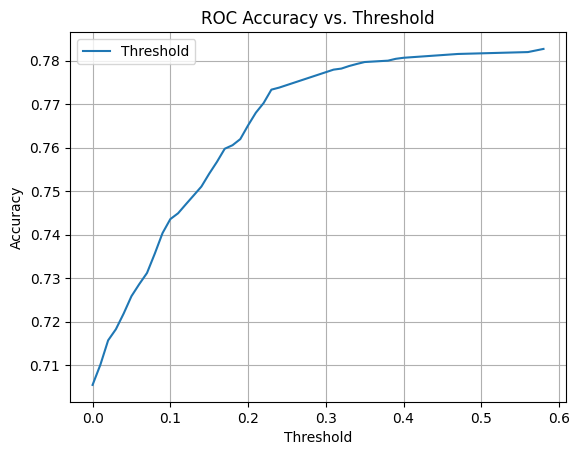

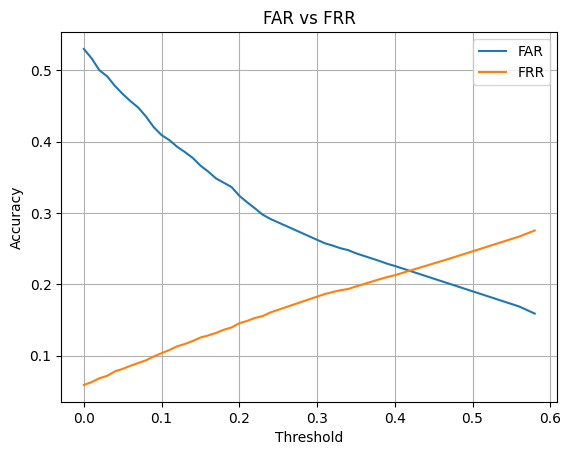

(0.7827074981082716, 0.58, 0.15906266642996625, 0.27552233735349074)

In [37]:
max_acc, threshold,far,frr = far_frr(np.array(pred), np.array(tr_y))
max_acc, threshold,far[-1],frr[-1]

| State-of-the-art Method  | #Signers |  Accuracy   | FAR  | FRR  |
|--------------------------|----------|-------------|------|------|
| SigNet                   |   160    |    78.27%   | 0.15 | 0.27 |

#### Accuracy = 78.27% and Threshold = 0.58
> Thus if the differnce score is less than 0.58, we predict the test image as Genuine and if the difference score is greater than 0.58, we predict it to be as forged

### Common metrics used to evaluate the performance of biometric systems, such as signature verification.
* **False Acceptance Rate (FAR)**: The rate at which unauthorized persons are incorrectly accepted by the system. This is calculated as the number of false acceptances divided by the total number of false acceptance opportunities (i.e., the total number of negative samples). Commonly known as ***False Positive Rate (FPR)***
    * FAR is calculated as FP / (FP + TN).


* **False Rejection Rate (FRR)**: The rate at which authorized persons are incorrectly rejected by the system. This is calculated as the number of false rejections divided by the total number of false rejection opportunities (i.e., the total number of positive samples). Commonly known as ***False Negative Rate (FNR)***
    * FRR is calculated as FN / (FN + TP).

In [38]:
from sklearn.metrics import classification_report

pred_binary = np.array(pred) <= threshold

print(classification_report(tr_y, pred_binary))

              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77      5887
         1.0       0.74      0.84      0.79      5633

    accuracy                           0.78     11520
   macro avg       0.79      0.78      0.78     11520
weighted avg       0.79      0.78      0.78     11520



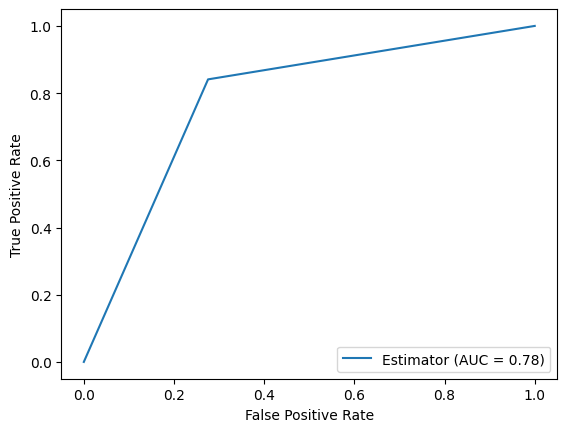

In [52]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(tr_y, pred_binary)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Estimator')
display.plot()
plt.show()

#### Below we see some sample results

In [40]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1[0]), cmap='gray')
    ax2.imshow(np.squeeze(img2[0]), cmap='gray')
    ax1.set_title('Genuine')
    if test_label[0] == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a FORGED Signature")
    else:
        print("Its a GENUINE Signature")

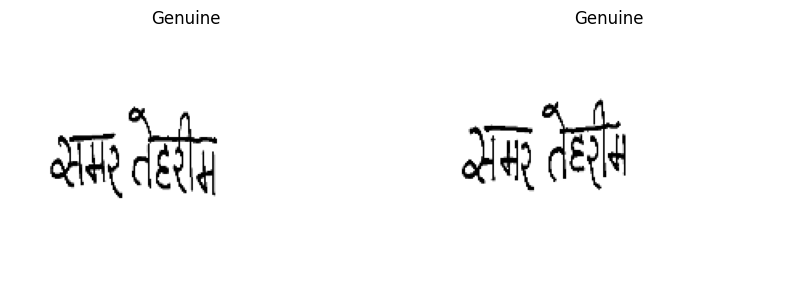

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step
Difference Score =  0.11766237
Its a GENUINE Signature


In [41]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

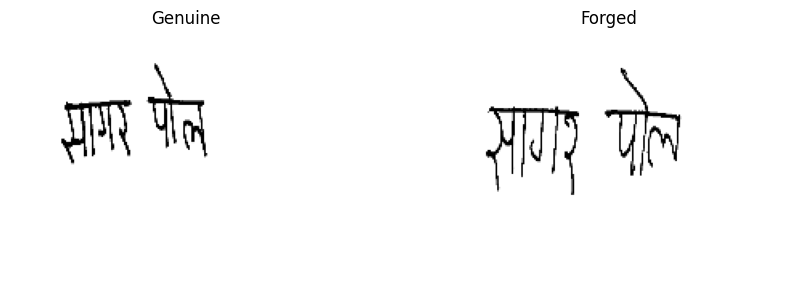

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step
Difference Score =  1.0770365
Its a FORGED Signature


In [42]:
predict_score()

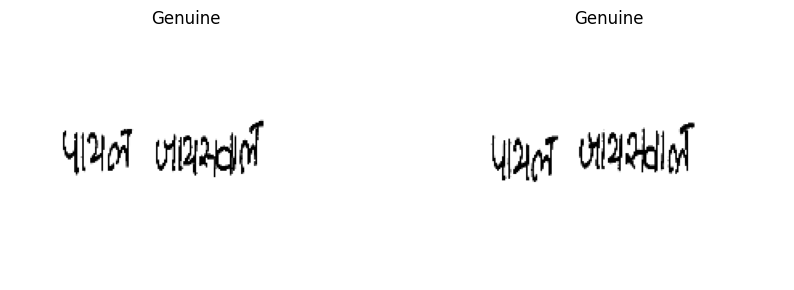

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [50]:
predict_score()

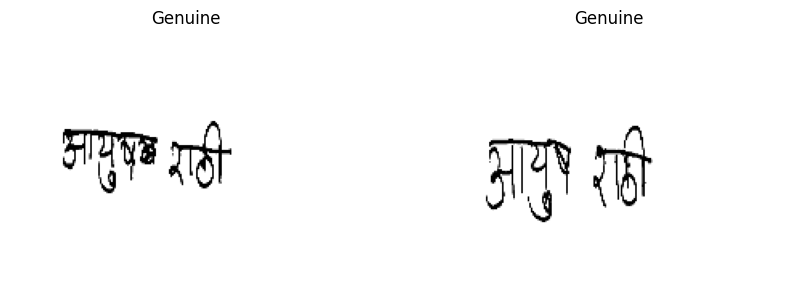

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step
Difference Score =  0.29535794
Its a GENUINE Signature


In [44]:
predict_score()

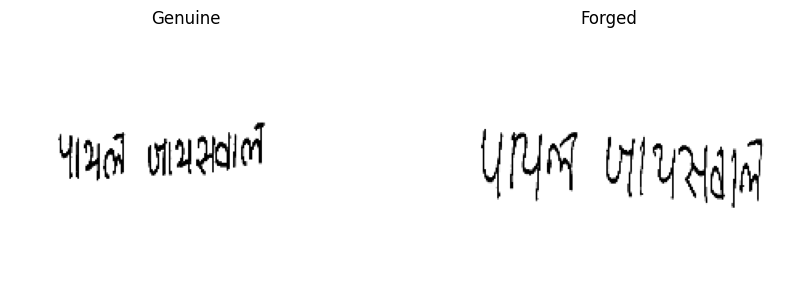

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step
Difference Score =  0.5892826
Its a FORGED Signature


In [51]:
predict_score()

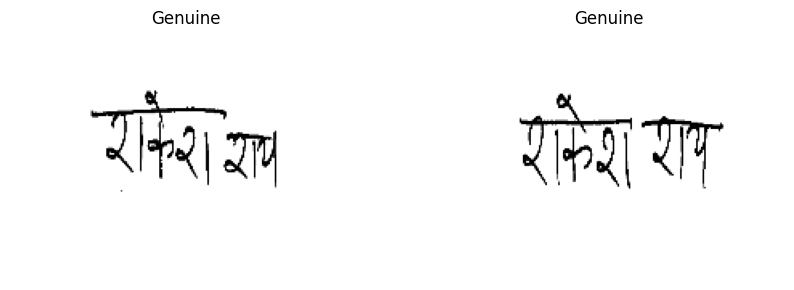

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
Difference Score =  0.0985685
Its a GENUINE Signature


In [46]:
predict_score()

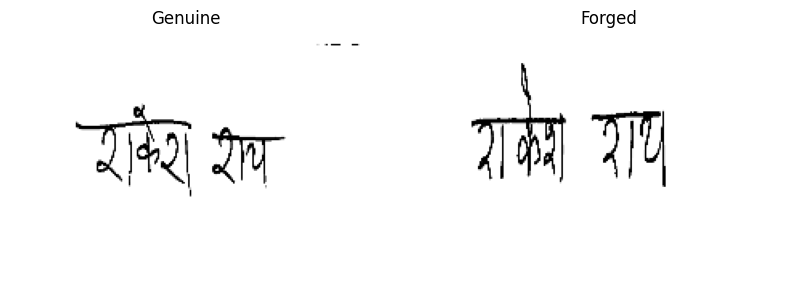

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step
Difference Score =  1.0596564
Its a FORGED Signature


In [47]:
predict_score()

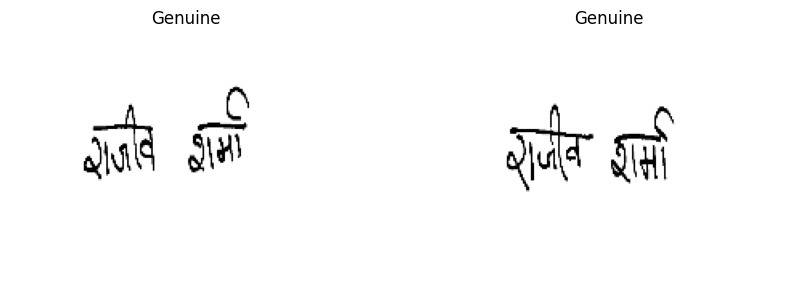

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [48]:
predict_score()

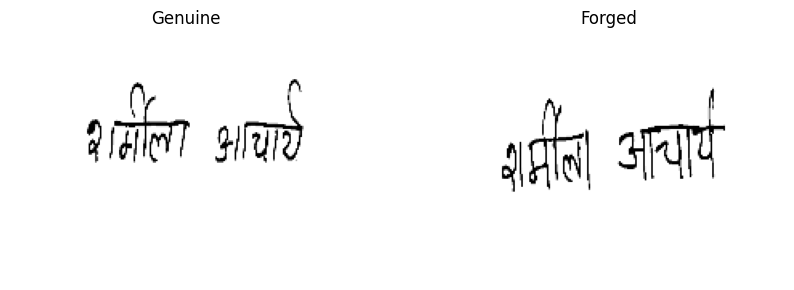

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
Difference Score =  0.03174287
Its a GENUINE Signature


In [49]:
predict_score()

# Further Improvements
> * **Hyperparameter Tuning**. Currently using huperparameter values used in the paper
> * **Increase Training dataset**. Can create additional 50k training point using same dataset
> * **Train for 100 epch**. As for demonstation purpose I have trained only till 20 epoch and the loss was still decreasing

# THE END